plot the topography (elevation & slope) of the primary forest distribution and lost primary forest

In [1]:
import numpy as np
import os
from os.path import join
from osgeo import gdal, gdal_array, gdalconst
import matplotlib.pyplot as plt
import matplotlib
from scipy.interpolate import interpn
from matplotlib.colors import ListedColormap


def get_pf_distribution_topography(land_cover, land_cover_flag, img_country, img_dem, img_slope):
    """
        get the topography (elevation and slope) of primary forest distribution in Haiti and the Dominican Republic
    Args:
        land_cover:
        land_cover_flag:
        img_country:
        img_dem:
        img_slope:

    Returns:

    """

    mask_haiti_pf_wet = (land_cover == land_cover_flag) & (img_country == 1)
    mask_dr_pf_wet = (land_cover == land_cover_flag) & (img_country == 2)

    haiti_pf_dem = img_dem[mask_haiti_pf_wet]
    haiti_pf_slope = img_slope[mask_haiti_pf_wet]

    dr_pf_dem = img_dem[mask_dr_pf_wet]
    dr_pf_slope = img_slope[mask_dr_pf_wet]

    return haiti_pf_dem, haiti_pf_slope, dr_pf_dem, dr_pf_slope


def get_pf_loss_topography(img_lc_1996, img_lc_2022, img_country_mask, img_dem, img_slope):
    """
        get the topography (elevation and slope) of lost primary forest in Haiti and the Dominican Republic
    Args:
        img_lc_1996:
        img_lc_2022:
        img_country_mask:
        img_dem:
        img_slope:

    Returns:
    """

    mask_haiti_pf_wet_loss = (img_lc_1996 == 2) & (img_lc_2022 != 2) & (img_country_mask == 1)

    haiti_pwf_loss_elevation = img_dem[mask_haiti_pf_wet_loss]
    haiti_pwf_loss_slope = img_slope[mask_haiti_pf_wet_loss]

    mask_haiti_pf_dry_loss = (img_lc_1996 == 3) & (img_lc_2022 != 3) & (img_country_mask == 1)

    haiti_pdf_loss_elevation = img_dem[mask_haiti_pf_dry_loss]
    haiti_pdf_loss_slope = img_slope[mask_haiti_pf_dry_loss]

    mask_dr_pf_wet_loss = (img_lc_1996 == 2) & (img_lc_2022 != 2) & (img_country_mask == 2)

    dr_pwf_loss_elevation = img_dem[mask_dr_pf_wet_loss]
    dr_pwf_loss_slope = img_slope[mask_dr_pf_wet_loss]

    mask_dr_pf_dry_loss = (img_lc_1996 == 3) & (img_lc_2022 != 3) & (img_country_mask == 2)

    dr_pdf_loss_elevation = img_dem[mask_dr_pf_dry_loss]
    dr_pdf_loss_slope = img_slope[mask_dr_pf_dry_loss]

    return (haiti_pwf_loss_elevation, haiti_pwf_loss_slope, haiti_pdf_loss_elevation, haiti_pdf_loss_slope,
            dr_pwf_loss_elevation, dr_pwf_loss_slope, dr_pdf_loss_elevation, dr_pdf_loss_slope)


def get_density_info(x, y):
    data, x_e, y_e = np.histogram2d(x, y, bins=[100, 100])
    z = interpn((0.5 * (x_e[1:] + x_e[:-1]), 0.5 * (y_e[1:] + y_e[:-1])), data, np.vstack([x, y]).T, method="splinef2d", bounds_error=False)

    # To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    return x, y, z


def plot_distribution_density(haiti_pwf_dem, haiti_pwf_slope, haiti_pdf_dem, haiti_pdf_slope,
                              x_label='', y_label='', title='',
                              cbar_1_label='primary wet forest',
                              cbar_2_label='primary dry forest',
                              figsize=(16, 10)
                              ):
    """
        plot the scatter density of the topography distribution of primary forest or lost PF in Haiti or DR
    """

    matplotlib.rcParams['font.family'] = "Arial"

    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=figsize)
    tick_label_size = 32
    axis_label_size = 36
    cbar_tick_label_size = 20
    title_label_size = 30
    tick_length = 4

    cmap = ListedColormap(matplotlib.colormaps.get_cmap('Greens')(np.linspace(0.2, 1, 100)))
    x, y, z = get_density_info(haiti_pwf_dem, haiti_pwf_slope)
    img = ax.scatter(x, y, c=z, s=10, cmap=cmap)
    cb = plt.colorbar(img, cmap=cmap)
    cb.ax.tick_params(labelsize=cbar_tick_label_size)
    cb.ax.set_ylabel(cbar_1_label, size=axis_label_size)

    cmap = ListedColormap(matplotlib.colormaps.get_cmap('Oranges')(np.linspace(0.2, 1, 100)))
    x, y, z = get_density_info(haiti_pdf_dem, haiti_pdf_slope)
    img = ax.scatter(x, y, c=z, s=10, cmap=cmap)
    cb = plt.colorbar(img, cmap=cmap)
    cb.ax.tick_params(labelsize=cbar_tick_label_size)
    cb.ax.set_ylabel(cbar_2_label, size=axis_label_size)

    ax.tick_params('x', labelsize=tick_label_size, direction='out', length=tick_length, bottom=True)
    ax.tick_params('y', labelsize=tick_label_size, direction='out', length=tick_length, left=True)

    ax.set_xlabel(x_label, size=axis_label_size)
    ax.set_ylabel(y_label, size=axis_label_size)

    ax.set_title(title, size=title_label_size)

    plt.show()

In [2]:
pwd = os.getcwd()
rootpath = os.path.abspath(os.path.join(pwd, '..'))

img_country_mask = gdal_array.LoadFile(join(rootpath, 'data', 'hispaniola_polygon', 'countryid_hispaniola.tif'))

img_dem = gdal_array.LoadFile(join(rootpath, 'data', 'topography', 'dem_mosaic.tif'))
img_slope = gdal_array.LoadFile(join(rootpath, 'data', 'topography', 'slope_mosaic.tif'))

img_lc_1996 = gdal_array.LoadFile(join(rootpath, 'data', 'hispaniola_lc', f'hispaniola_lc_{1996}.tif'))
img_lc_2022 = gdal_array.LoadFile(join(rootpath, 'data', 'hispaniola_lc', f'hispaniola_lc_{2022}.tif'))

In [3]:
haiti_pwf_dem, haiti_pwf_slope, dr_pwf_dem, dr_pwf_slope = get_pf_distribution_topography(img_lc_1996, 2, img_country_mask, img_dem, img_slope)
haiti_pdf_dem, haiti_pdf_slope, dr_pdf_dem, dr_pdf_slope = get_pf_distribution_topography(img_lc_1996, 3, img_country_mask, img_dem, img_slope)

(haiti_pwf_loss_dem, haiti_pwf_loss_slope, haiti_pdf_loss_dem, haiti_pdf_loss_slope,
 dr_pwf_loss_dem, dr_pwf_loss_slope, dr_pdf_loss_dem, dr_pdf_loss_slope) = get_pf_loss_topography(img_lc_1996, img_lc_2022, img_country_mask, img_dem, img_slope)

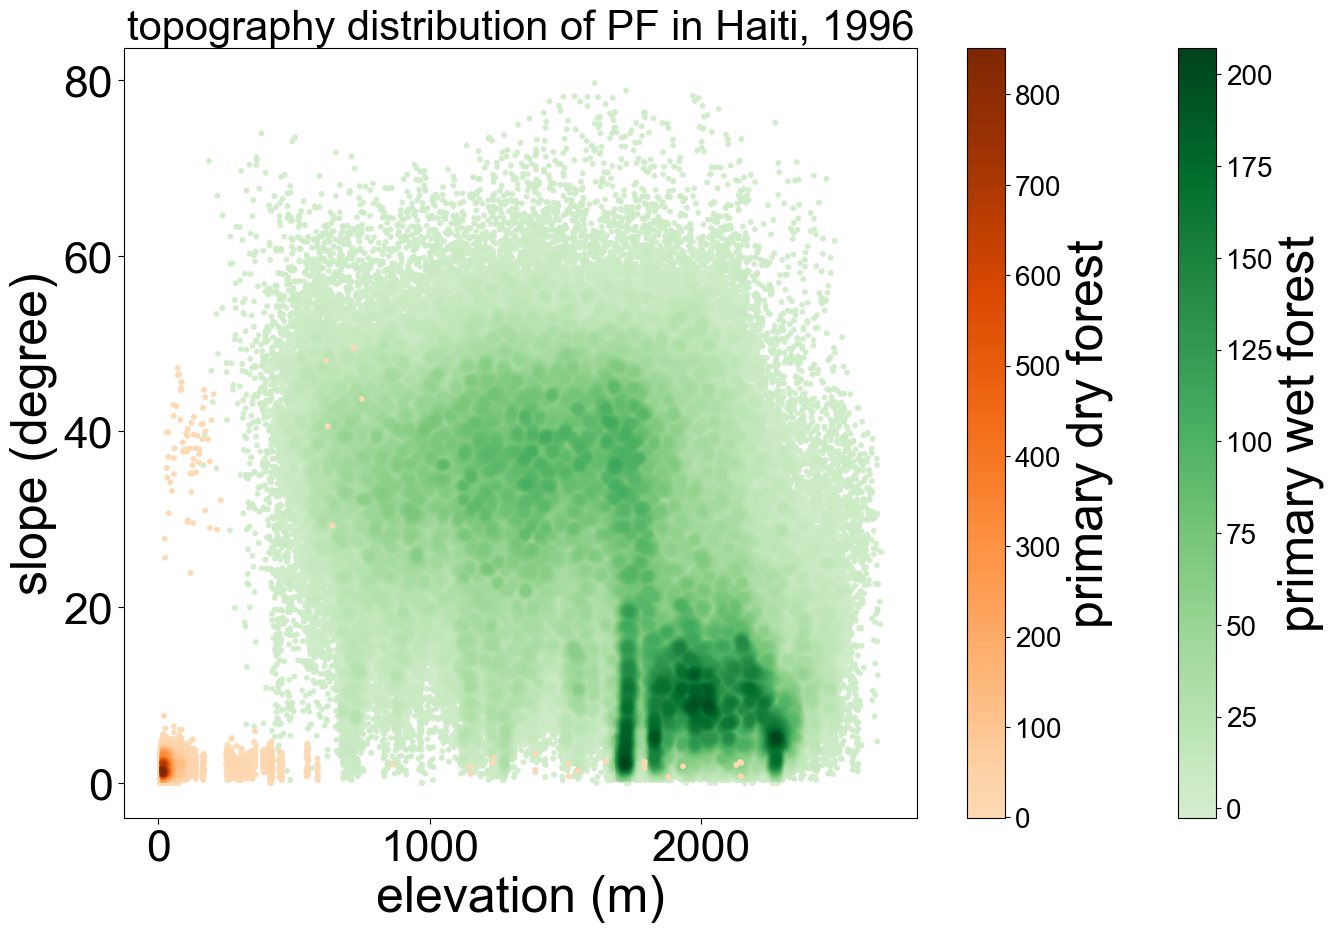

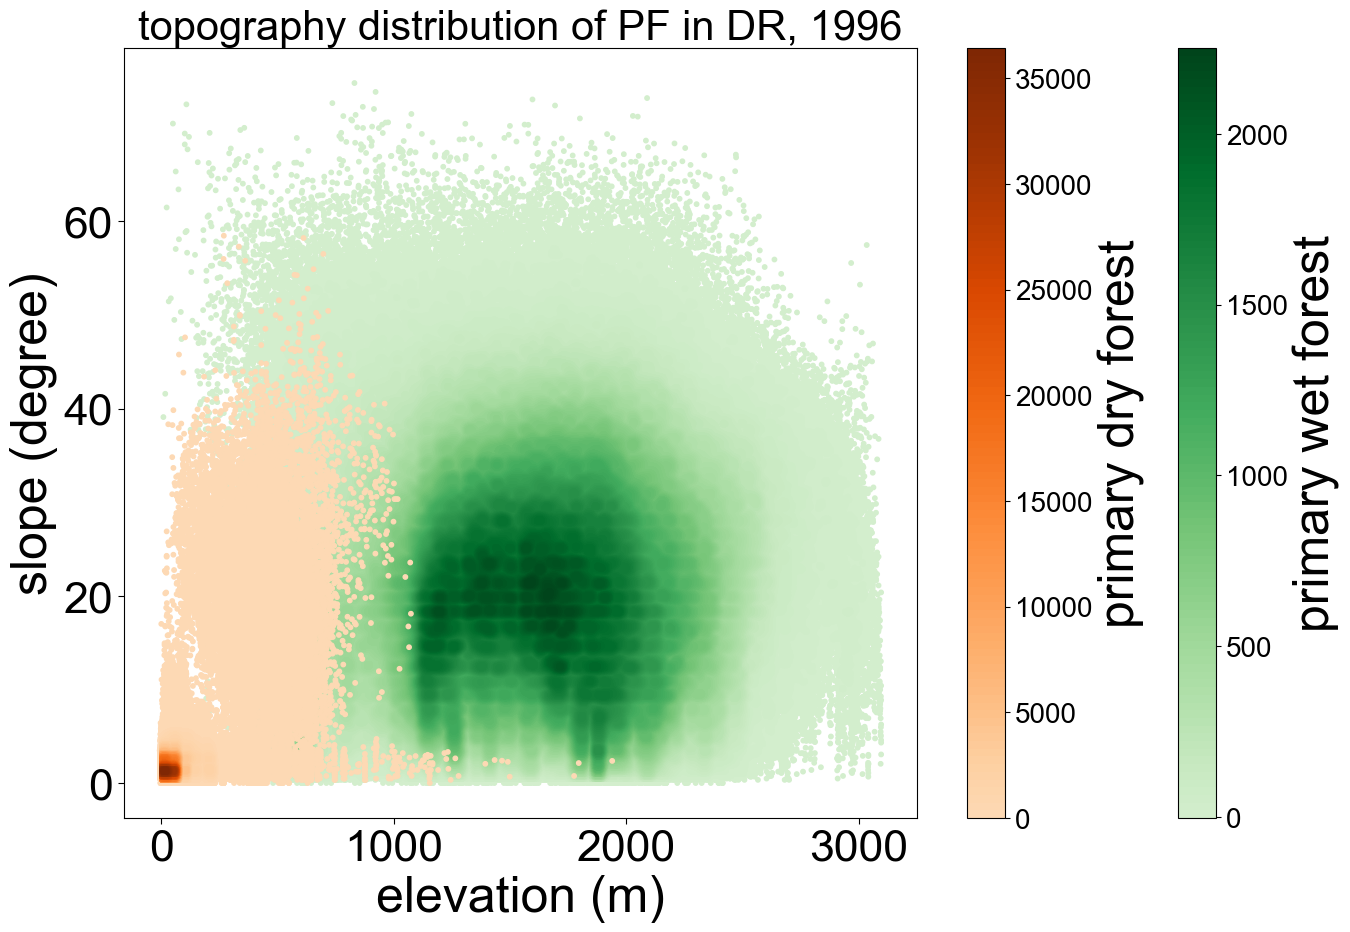

In [4]:
plot_distribution_density(haiti_pwf_dem, haiti_pwf_slope, haiti_pdf_dem, haiti_pdf_slope,
                          x_label='elevation (m)', y_label='slope (degree)',
                          title='topography distribution of PF in Haiti, 1996',
                          )

plot_distribution_density(dr_pwf_dem, dr_pwf_slope, dr_pdf_dem, dr_pdf_slope,
                          x_label='elevation (m)', y_label='slope (degree)',
                          title='topography distribution of PF in DR, 1996',
                          )

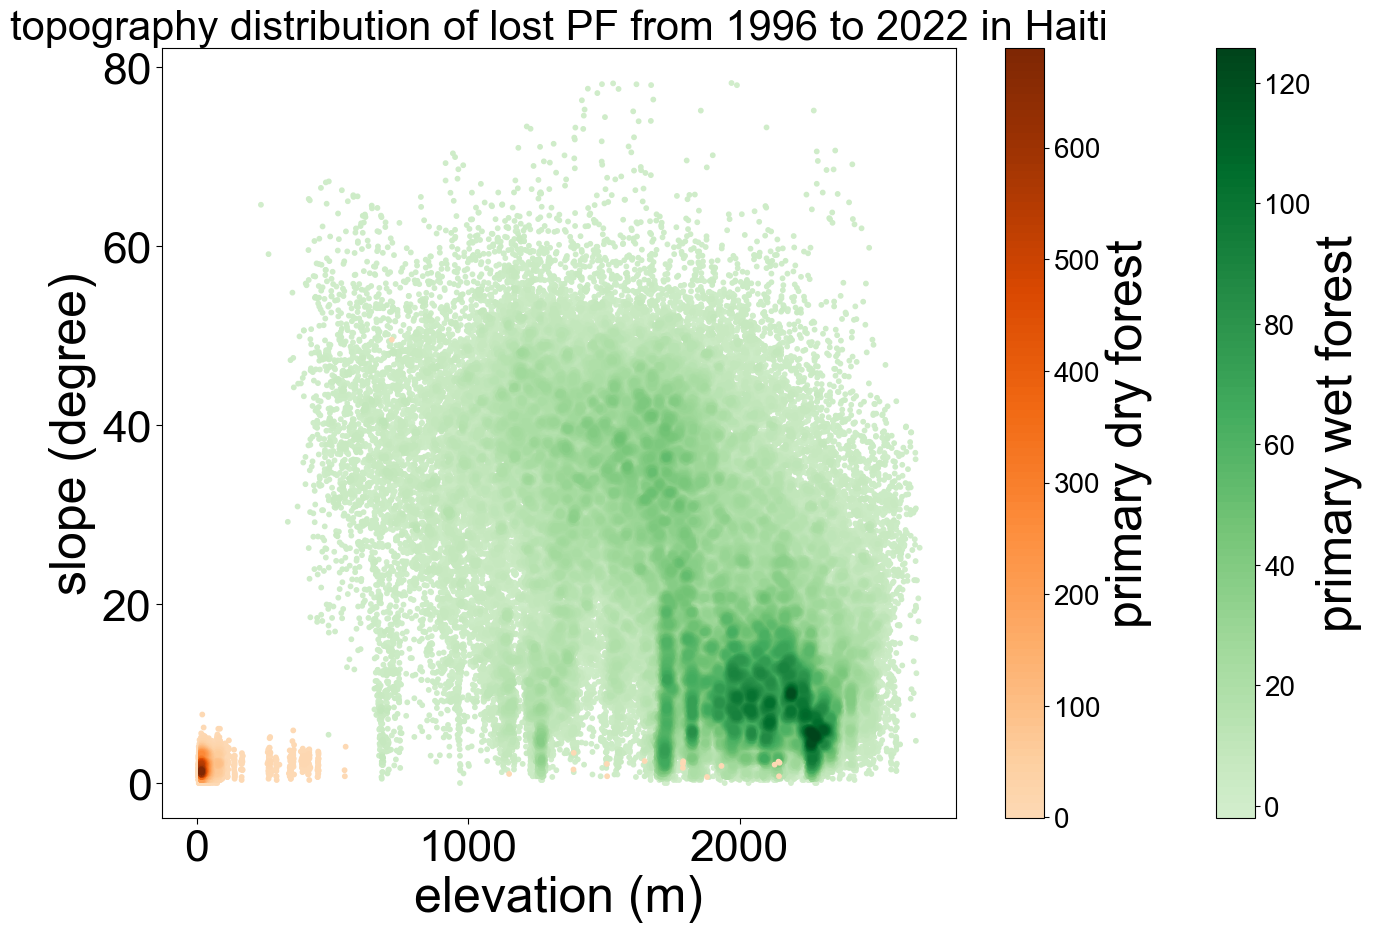

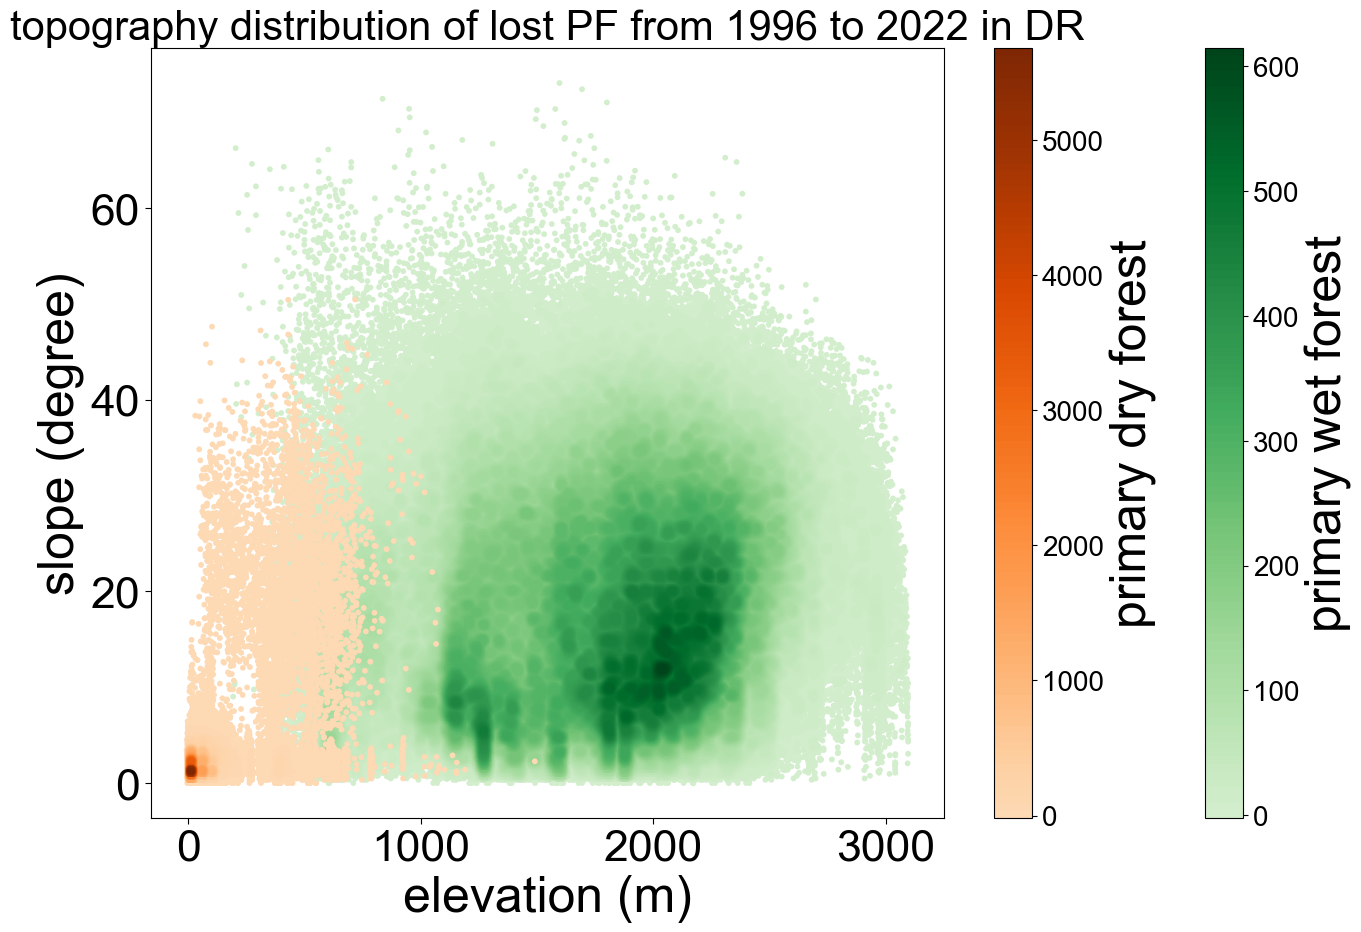

In [5]:
plot_distribution_density(haiti_pwf_loss_dem, haiti_pwf_loss_slope, haiti_pdf_loss_dem, haiti_pdf_loss_slope,
                          x_label='elevation (m)', y_label='slope (degree)',
                          title='topography distribution of lost PF from 1996 to 2022 in Haiti',
                          )

plot_distribution_density(dr_pwf_loss_dem, dr_pwf_loss_slope, dr_pdf_loss_dem, dr_pdf_loss_slope,
                          x_label='elevation (m)', y_label='slope (degree)',
                          title='topography distribution of lost PF from 1996 to 2022 in DR',
                          )